In [1]:
import matplotlib.pyplot as plt
import pandas as pd
import seaborn as sns
import pickle as pkl
import sklearn.metrics as skmetrics
import json

default_palette = list(sns.color_palette().as_hex())

In [2]:
results_df = pd.read_json('results/overall_results.json')
results_df = results_df.transpose()
# only 30% test data; dont use
#rows_trivia_m10 = results_df.index.isin(['3a36kjqy', '16xto1lu', '18hihnlx', '8wkscsiw', '5chgzy2b', '1gg4jlam'])
rows_trivia_m10 = results_df.index.isin(['34webe3u', 'r6bcg0j0', 'q7jwqjuc', '2e9bcge4', '1fg1y4wi', '1rj7gglg'])
rows_coqa_m10 = results_df.index.isin(['23c3fv0w', '3v2qeuf7', '1j098ghp', 'jea2wag5', '216am2ai', '23u1xur9'])
rows_coqa_m20 = results_df.index.isin(['vqsivevv', '386igsi5', '2yotsedc', '3aws5stu', '38nlrhxa', '349oybw1'])
# model name as row name
results_df = results_df.set_index('model_name')
k_ent_keys = [key for key in results_df.columns if 'k_entropy_' in key]
keys_to_plot = [
    'accuracy', 'predictive_entropy_auroc', 'ln_predictive_entropy_auroc', 'p_true_auroc', 
    'entropy_over_concepts_auroc', 'average_rougeL_auroc'
]
results_df = results_df[k_ent_keys + keys_to_plot]
results_df.columns = [name[:-6] if '_auroc' in name else name for name in results_df.columns]
rbf_ent_keys = [key for key in results_df.columns if 'k_entropy_rbf_' in key]
ker_keys = [
    'k_entropy_rbf_e5-small-v2', 'k_entropy_cos_e5-small-v2',
    'k_entropy_lap_e5-small-v2', 'k_entropy_pol_e5-small-v2'
]
keys_sota = [
    'predictive_entropy',
    'ln_predictive_entropy',
    'p_true',
    'entropy_over_concepts',
    'average_rougeL',
]
keys_sota_renamed = ['Predictive Entropy', 'Normalised Entropy', 'p(True)', 'Semantic Entropy', 'Lexical Similarity']
rename_mapping = {k: v for k, v in zip(keys_sota, keys_sota_renamed)}
results_df.rename(columns=rename_mapping, inplace=True)
keys_sota_ext = [
    'predictive_entropy',
    'ln_predictive_entropy',
    'p_true',
    'entropy_over_concepts',
    'average_rougeL',
    #'k_entropy_cos_gte-large',
    'k_entropy_rbf_e5-small-v2'
]
chosen_embedder = 'k_entropy_rbf_e5-small-v2'

       Model   Dataset       Uncertainty     AUROC
36  opt-125m  TriviaQA  Semantic Entropy  0.507761
37  opt-350m  TriviaQA  Semantic Entropy  0.434131
38  opt-1.3b  TriviaQA  Semantic Entropy  0.613325
39  opt-2.7b  TriviaQA  Semantic Entropy  0.662419
40  opt-6.7b  TriviaQA  Semantic Entropy  0.703629
41   opt-13b  TriviaQA  Semantic Entropy  0.715971
42  opt-125m      CoQA  Semantic Entropy  0.553225
43  opt-350m      CoQA  Semantic Entropy  0.562366
44  opt-1.3b      CoQA  Semantic Entropy   0.66702
45  opt-2.7b      CoQA  Semantic Entropy  0.690236
46  opt-6.7b      CoQA  Semantic Entropy  0.717521
47   opt-13b      CoQA  Semantic Entropy  0.737095


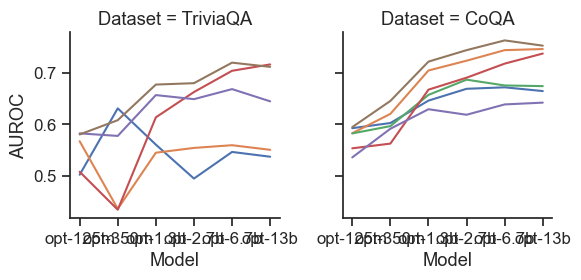

In [6]:
sns.set(font_scale=1.1)
sns.set_style('ticks')

sub_df = results_df.copy()
sub_df['Model'] = sub_df.index
sub_df['Dataset'] = None
sub_df['Dataset'][rows_coqa_m10] = 'CoQA'
sub_df['Dataset'][rows_coqa_m20] = 'CoQA'
sub_df['Dataset'][rows_trivia_m10] = 'TriviaQA'
sub_df = sub_df[rows_coqa_m20 | rows_trivia_m10]
sub_df = sub_df.melt(
    id_vars=['Model', 'Dataset'],
    value_vars=keys_sota_renamed+[chosen_embedder],
    var_name='Uncertainty',
    value_name='AUROC'
)
sub_df['Uncertainty'].replace({
    chosen_embedder: 'Kernel Entropy (ours)'
}, inplace=True)
print(sub_df)
plot = sns.FacetGrid(data=sub_df, col="Dataset")
plot = plot.map(sns.lineplot, 'Model', 'AUROC', 'Uncertainty')

/var/folders/ft/r9cj4sz92lbfcwssbtg9tp680000gp/T/ipykernel_4634/2719870918.py:38: UserWarning: Matplotlib is currently using module://matplotlib_inline.backend_inline, which is a non-GUI backend, so cannot show the figure.
  plot.figure.show();


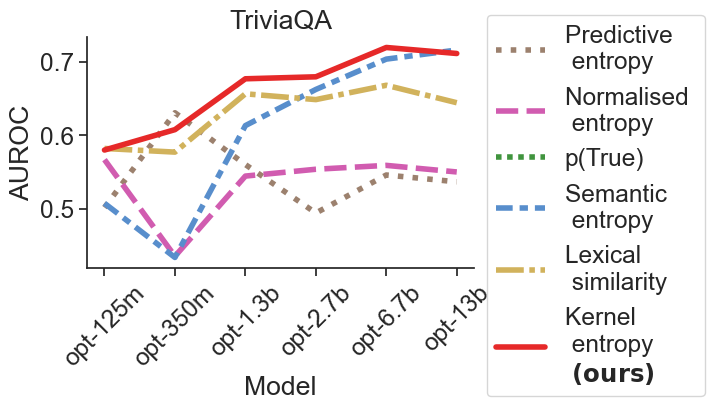

In [78]:
palette = {
    'Predictive \n entropy': '#9c816e',
    'Normalised \n entropy': '#d15cb0',
    'p(True)': '#40943e',
    'Lexical \n similarity': '#d1b25c', #'#949400',
    'Semantic \n entropy': '#588ecc',#'#1A92CA',
    'Kernel \n entropy \n $\mathbf{(ours)}$': '#e62929', #'#e63946',
}
plt.figure(figsize=(5, 3))
sns.set(font_scale=1.6)
sns.set_style('ticks')
line_size = 4

cols_rename = {
    chosen_embedder: 'Kernel \n entropy \n $\mathbf{(ours)}$',
    'Predictive Entropy': 'Predictive \n entropy',
    'Semantic Entropy': 'Semantic \n entropy',
    'Normalised Entropy': 'Normalised \n entropy',
    'Lexical Similarity': 'Lexical \n similarity',
}
sub_df = results_df[keys_sota_renamed+[chosen_embedder]][rows_trivia_m10].copy()
sub_df.rename(columns=cols_rename, inplace=True)
plot = sns.lineplot(data=sub_df, linewidth=line_size, palette=palette)
plot.set_title('TriviaQA')
plot.set_ylabel("AUROC")
plot.set_xlabel("Model")
plot.axes.tick_params(axis='x', rotation=45)
sns.despine(plot.figure)
lines = plt.legend().get_lines()
for line in lines:
    line.set_linewidth(4)
lines[0].set_linestyle('dotted')
lines[5].set_linestyle('-')
plot.axes.lines[0].set_linestyle('dotted')
plot.axes.lines[4].set_linestyle('-')
sns.move_legend(plot, "upper left", bbox_to_anchor=(1, 1.15))
plot.figure.savefig('plots/nlg_results_sota_ext_trivia_m10.pdf', bbox_inches='tight')
plot.figure.show();

/var/folders/ft/r9cj4sz92lbfcwssbtg9tp680000gp/T/ipykernel_4634/288319960.py:20: UserWarning: Matplotlib is currently using module://matplotlib_inline.backend_inline, which is a non-GUI backend, so cannot show the figure.
  plot.figure.show();


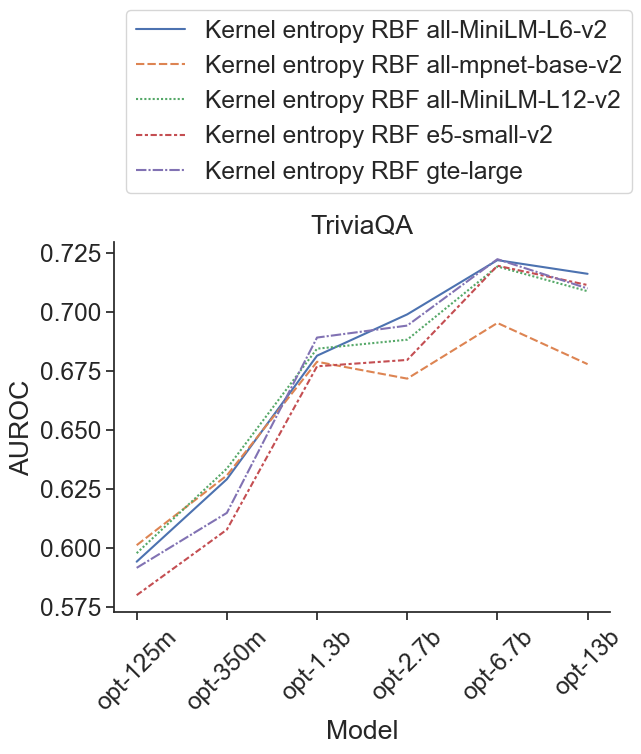

In [79]:
sns.set(font_scale=1.6)
sns.set_style('ticks')
sub_df = results_df[rbf_ent_keys][rows_trivia_m10].copy()
cols_rename = {
    'k_entropy_rbf_all-MiniLM-L6-v2': 'Kernel entropy RBF all-MiniLM-L6-v2',
    'k_entropy_rbf_all-mpnet-base-v2': 'Kernel entropy RBF all-mpnet-base-v2',
    'k_entropy_rbf_all-MiniLM-L12-v2': 'Kernel entropy RBF all-MiniLM-L12-v2',
    'k_entropy_rbf_e5-small-v2': 'Kernel entropy RBF e5-small-v2',
    'k_entropy_rbf_gte-large': 'Kernel entropy RBF gte-large'
}
sub_df.rename(columns=cols_rename, inplace=True)
plot = sns.lineplot(data=sub_df)
plot.axes.tick_params(axis='x', rotation=45)
sns.despine(plot.figure)
plot.set_title('TriviaQA')
plot.set_ylabel("AUROC")
plot.set_xlabel("Model")
sns.move_legend(plot, "lower left", bbox_to_anchor=(0, 1.1))
plot.figure.savefig('plots/nlg_results_kernels_rbf_embeddings_trivia_m10.pdf', bbox_inches='tight')
plot.figure.show();

/var/folders/ft/r9cj4sz92lbfcwssbtg9tp680000gp/T/ipykernel_4634/381914886.py:19: UserWarning: Matplotlib is currently using module://matplotlib_inline.backend_inline, which is a non-GUI backend, so cannot show the figure.
  plot.figure.show();


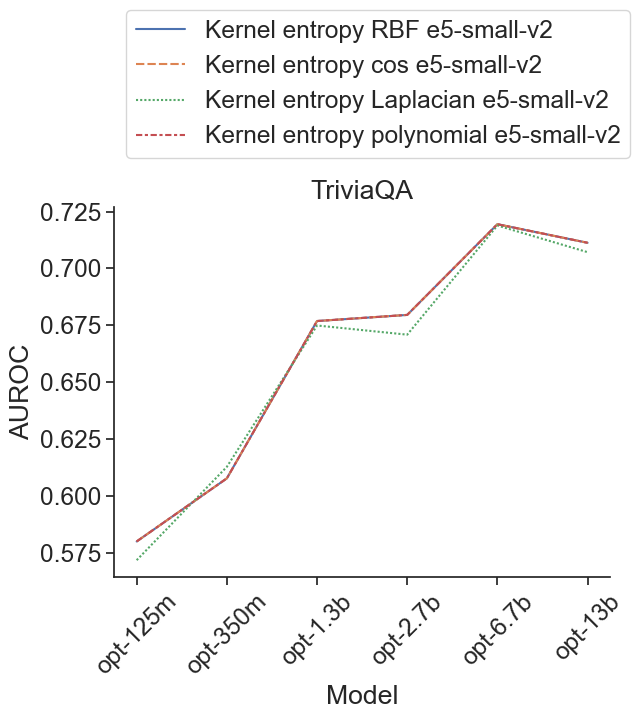

In [80]:
sns.set(font_scale=1.6)
sns.set_style('ticks')
cols_rename = {
    'k_entropy_rbf_e5-small-v2': 'Kernel entropy RBF e5-small-v2',
    'k_entropy_cos_e5-small-v2': 'Kernel entropy cos e5-small-v2',
    'k_entropy_lap_e5-small-v2': 'Kernel entropy Laplacian e5-small-v2',
    'k_entropy_pol_e5-small-v2': 'Kernel entropy polynomial e5-small-v2',
}
sub_df = results_df[ker_keys][rows_trivia_m10].copy()
sub_df.rename(columns=cols_rename, inplace=True)
plot = sns.lineplot(data=sub_df)
plot.axes.tick_params(axis='x', rotation=45)
sns.despine(plot.figure)
plot.set_title('TriviaQA')
plot.set_ylabel("AUROC")
plot.set_xlabel("Model")
sns.move_legend(plot, "lower left", bbox_to_anchor=(0, 1.1))
plot.figure.savefig('plots/nlg_results_kernels_kernels_trivia_m10.pdf', bbox_inches='tight')
plot.figure.show();

/var/folders/ft/r9cj4sz92lbfcwssbtg9tp680000gp/T/ipykernel_4634/3789992902.py:23: UserWarning: Matplotlib is currently using module://matplotlib_inline.backend_inline, which is a non-GUI backend, so cannot show the figure.
  plot.figure.show();


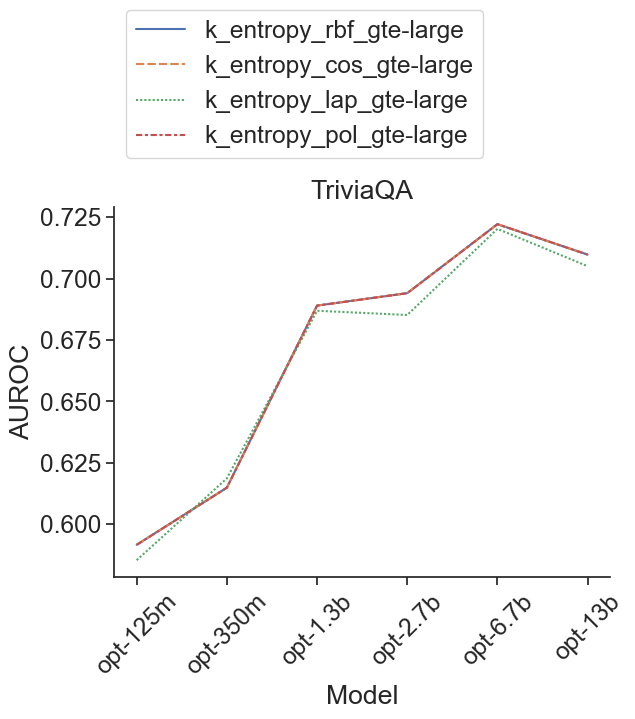

In [81]:
sns.set(font_scale=1.6)
sns.set_style('ticks')
# cols_rename = {
#     'k_entropy_rbf_e5-small-v2': 'Kernel entropy RBF e5-small-v2',
#     'k_entropy_cos_e5-small-v2': 'Kernel entropy cos e5-small-v2',
#     'k_entropy_lap_e5-small-v2': 'Kernel entropy Laplacian e5-small-v2',
#     'k_entropy_pol_e5-small-v2': 'Kernel entropy polynomial e5-small-v2',
# }
keys_cos_gte = [
    'k_entropy_rbf_gte-large', 'k_entropy_cos_gte-large',
    'k_entropy_lap_gte-large', 'k_entropy_pol_gte-large'
]
sub_df = results_df[keys_cos_gte][rows_trivia_m10].copy()
sub_df.rename(columns=cols_rename, inplace=True)
plot = sns.lineplot(data=sub_df)
plot.axes.tick_params(axis='x', rotation=45)
sns.despine(plot.figure)
plot.set_title('TriviaQA')
plot.set_ylabel("AUROC")
plot.set_xlabel("Model")
sns.move_legend(plot, "lower left", bbox_to_anchor=(0, 1.1))
#plot.figure.savefig('plots/nlg_results_kernels_kernels_trivia_m10.pdf', bbox_inches='tight')
plot.figure.show();

/var/folders/ft/r9cj4sz92lbfcwssbtg9tp680000gp/T/ipykernel_4634/3053704834.py:25: UserWarning: Matplotlib is currently using module://matplotlib_inline.backend_inline, which is a non-GUI backend, so cannot show the figure.
  plot.figure.show();


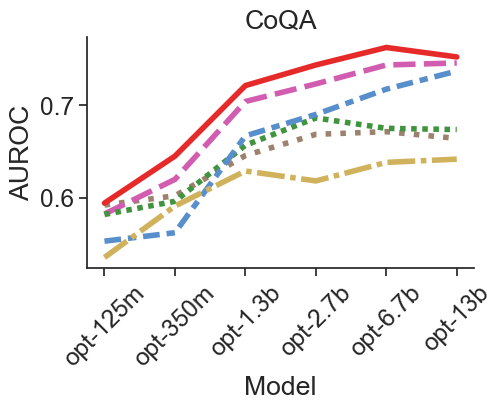

In [82]:
palette = {
    'Predictive Entropy': '#9c816e',
    'Normalised Entropy': '#d15cb0',
    'p(True)': '#40943e',
    'Lexical Similarity': '#d1b25c', #'#949400',
    'Semantic Entropy': '#588ecc',#'#1A92CA',
    'Kernel Entropy (ours)': '#e62929', #'#e63946',
}
plt.figure(figsize=(5, 3))
sns.set(font_scale=1.6)
sns.set_style('ticks')
line_size = 4

sub_df = results_df.rename(columns={'k_entropy_rbf_e5-small-v2': 'Kernel Entropy (ours)'}).copy()
sub_df = sub_df[keys_sota_renamed+['Kernel Entropy (ours)']][rows_coqa_m20]
plot = sns.lineplot(data=sub_df, linewidth=line_size, legend=False, palette=palette)
plot.set_ylabel("AUROC")
plot.set_xlabel("Model")
plot.set_title('CoQA')
plot.axes.tick_params(axis='x', rotation=45)
sns.despine(plot.figure)
plot.axes.lines[0].set_linestyle('dotted')
plot.axes.lines[5].set_linestyle('-')
plot.figure.savefig('plots/nlg_results_sota_coqa_m20.pdf', bbox_inches='tight')
plot.figure.show();

/var/folders/ft/r9cj4sz92lbfcwssbtg9tp680000gp/T/ipykernel_4634/1772566759.py:20: UserWarning: Matplotlib is currently using module://matplotlib_inline.backend_inline, which is a non-GUI backend, so cannot show the figure.
  plot.figure.show();


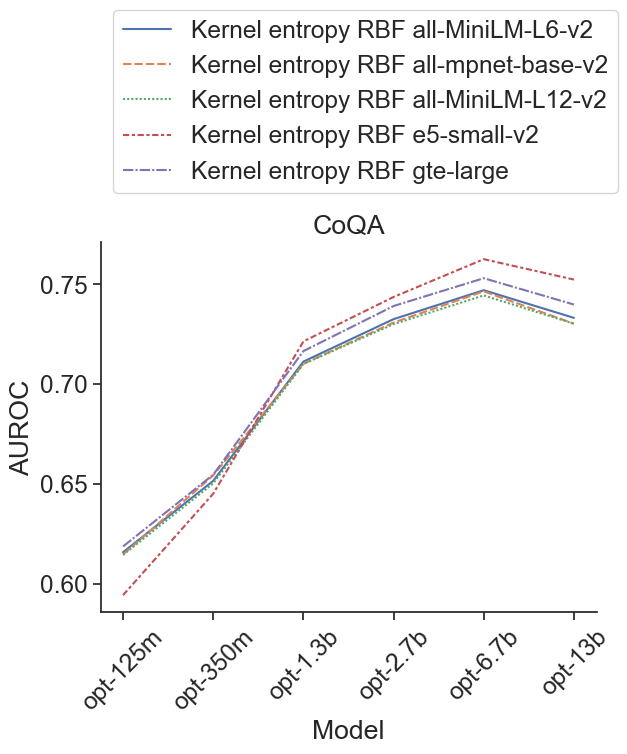

In [83]:
sns.set(font_scale=1.6)
sns.set_style('ticks')
cols_rename = {
    'k_entropy_rbf_all-MiniLM-L6-v2': 'Kernel entropy RBF all-MiniLM-L6-v2',
    'k_entropy_rbf_all-mpnet-base-v2': 'Kernel entropy RBF all-mpnet-base-v2',
    'k_entropy_rbf_all-MiniLM-L12-v2': 'Kernel entropy RBF all-MiniLM-L12-v2',
    'k_entropy_rbf_e5-small-v2': 'Kernel entropy RBF e5-small-v2',
    'k_entropy_rbf_gte-large': 'Kernel entropy RBF gte-large'
}
sub_df = results_df[rbf_ent_keys][rows_coqa_m20].copy()
sub_df.rename(columns=cols_rename, inplace=True)
plot = sns.lineplot(data=sub_df)
sns.despine(plot.figure)
plot.axes.tick_params(axis='x', rotation=45)
plot.set_title('CoQA')
plot.set_ylabel("AUROC")
plot.set_xlabel("Model")
sns.move_legend(plot, "lower left", bbox_to_anchor=(0, 1.1))
plot.figure.savefig('plots/nlg_results_kernels_rbf_embeddings_coqa_m20.pdf', bbox_inches='tight')
plot.figure.show();

/var/folders/ft/r9cj4sz92lbfcwssbtg9tp680000gp/T/ipykernel_4634/3549390487.py:19: UserWarning: Matplotlib is currently using module://matplotlib_inline.backend_inline, which is a non-GUI backend, so cannot show the figure.
  plot.figure.show();


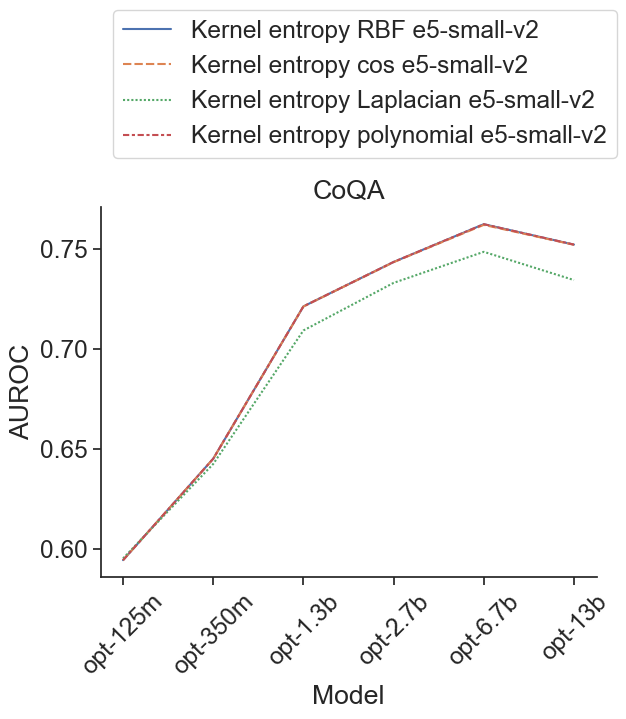

In [84]:
sns.set(font_scale=1.6)
sns.set_style('ticks')
cols_rename = {
    'k_entropy_rbf_e5-small-v2': 'Kernel entropy RBF e5-small-v2',
    'k_entropy_cos_e5-small-v2': 'Kernel entropy cos e5-small-v2',
    'k_entropy_lap_e5-small-v2': 'Kernel entropy Laplacian e5-small-v2',
    'k_entropy_pol_e5-small-v2': 'Kernel entropy polynomial e5-small-v2',
}
sub_df = results_df[ker_keys][rows_coqa_m20].copy()
sub_df.rename(columns=cols_rename, inplace=True)
plot = sns.lineplot(data=sub_df)
sns.despine(plot.figure)
plot.axes.tick_params(axis='x', rotation=45)
plot.set_title('CoQA')
plot.set_ylabel("AUROC")
plot.set_xlabel("Model")
sns.move_legend(plot, "lower left", bbox_to_anchor=(0, 1.1))
plot.figure.savefig('plots/nlg_results_kernels_kernels_coqa_m20.pdf', bbox_inches='tight')
plot.figure.show();

/var/folders/ft/r9cj4sz92lbfcwssbtg9tp680000gp/T/ipykernel_4634/1269459582.py:47: UserWarning: Matplotlib is currently using module://matplotlib_inline.backend_inline, which is a non-GUI backend, so cannot show the figure.
  plot.figure.show();


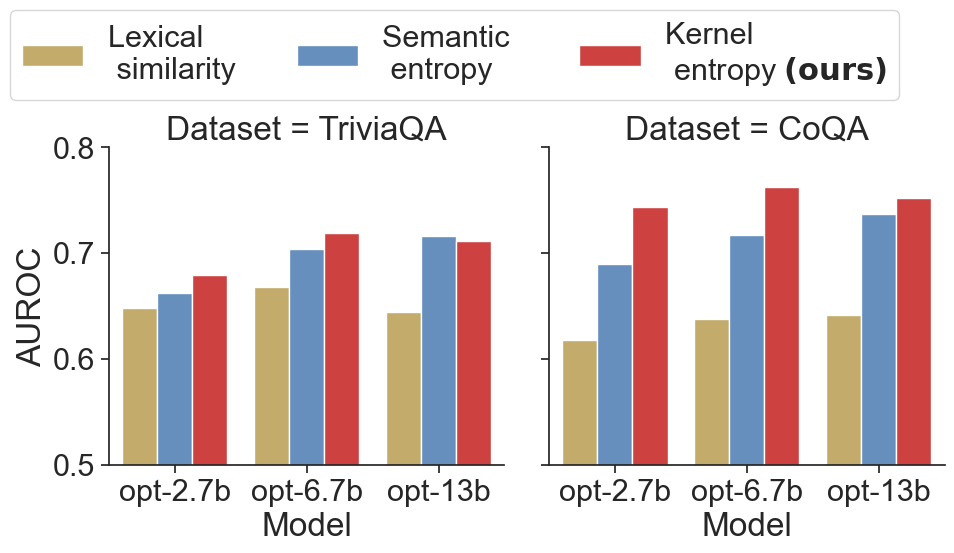

In [85]:
palette = {
    'Lexical \n similarity': '#d1b25c', #'#949400',
    'Semantic \n entropy': '#588ecc',#'#1A92CA',
    'Kernel \n entropy $\mathbf{(ours)}$': '#e62929', #'#e63946',
}
sns.set(font_scale=2)
sns.set_style('ticks')
sub_results = results_df[['Lexical Similarity', 'Semantic Entropy', 'k_entropy_rbf_e5-small-v2']].copy()
sub_results = sub_results.reset_index()
sub_results['Dataset'] = None
sub_results['Dataset'][rows_coqa_m10] = 'CoQA'
sub_results['Dataset'][rows_coqa_m20] = 'CoQA'
sub_results['Dataset'][rows_trivia_m10] = 'TriviaQA'
sub_results = sub_results[rows_coqa_m20 | rows_trivia_m10]
sub_results = sub_results[sub_results['model_name'].isin(['opt-2.7b', 'opt-6.7b', 'opt-13b',])]
sub_results = sub_results.melt(
    id_vars=['model_name', 'Dataset'],
    value_vars=['Lexical Similarity', 'Semantic Entropy', 'k_entropy_rbf_e5-small-v2'],
    var_name='Uncertainty',
    value_name='AUROC'
)
sub_results['Model'] = sub_results['model_name']
sub_results['Uncertainty'].replace({
    'k_entropy_rbf_e5-small-v2': 'Kernel \n entropy $\mathbf{(ours)}$',
    'Lexical Similarity': 'Lexical \n similarity',
    'Semantic Entropy': 'Semantic \n entropy'
}, inplace=True)
plot = sns.catplot(
    data=sub_results,
    x='Model',
    y='AUROC',
    hue='Uncertainty',
    col='Dataset',
    kind='bar',
    legend=False,
    palette=palette
)
plot.set(ylim=(0.5, 0.8))
#plot.axes[0,0].tick_params(axis='x', rotation=45)
#plot.axes[0,1].tick_params(axis='x', rotation=45)
plot.axes[0,1].legend(
    loc="lower left",
    bbox_to_anchor=(-1.4, 1.1),
    ncol=3,
)
plot.figure.savefig('plots/nlg_results_money_plot.pdf', bbox_inches='tight')
plot.figure.show();

In [86]:
with open(f'results/349oybw1_e5-small-v2_kernel_entropy_ablation.pkl', 'rb') as infile:
    kent_df = pkl.load(infile)

with open('results/overall_results.json', 'r') as f:
    overall_results = json.load(f)
pred_df = [
    {'AUROC': v, 'n_gens': i+1, 'rep_id': 0, 'Entropy': 'Predictive'}
    for i, v in enumerate(overall_results['349oybw1']['predictive_entropy_auroc_on_subsets'])
]
pred_df = pd.DataFrame(pred_df)
ln_pred_df = [
    {'AUROC': v, 'n_gens': i+1, 'rep_id': 0, 'Entropy': 'Normalized'}
    for i, v in enumerate(overall_results['349oybw1']['ln_predictive_entropy_auroc_on_subsets'])
]
ln_pred_df = pd.DataFrame(ln_pred_df)
sm_pred_df = [
    {'AUROC': v, 'n_gens': i+1, 'rep_id': 0, 'Entropy': 'Semantic'}
    for i, v in enumerate(overall_results['349oybw1']['semantic_predictive_entropy_auroc_on_subsets'])
]
sm_pred_df = pd.DataFrame(sm_pred_df)
overall_results = pd.concat([kent_df, sm_pred_df, pred_df, ln_pred_df])
overall_results

,rep_id,n_gens,AUROC,Entropy
0,0,2,0.633638,Kernel
1,0,3,0.677323,Kernel
2,0,4,0.698713,Kernel
3,0,5,0.709973,Kernel
4,0,6,0.717023,Kernel
...,...,...,...,...
15,0,16,0.745477,Normalized
16,0,17,0.745696,Normalized
17,0,18,0.745444,Normalized
18,0,19,0.745548,Normalized


/var/folders/ft/r9cj4sz92lbfcwssbtg9tp680000gp/T/ipykernel_4634/783217402.py:10: UserWarning: Matplotlib is currently using module://matplotlib_inline.backend_inline, which is a non-GUI backend, so cannot show the figure.
  plot.figure.show();


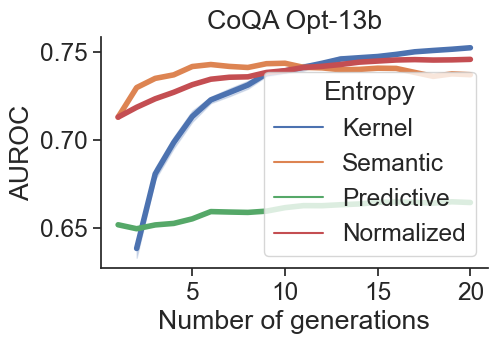

In [87]:
plt.figure(figsize=(5, 3))
sns.set(font_scale=1.6)
sns.set_style('ticks')
line_size = 4
plot = sns.lineplot(data=overall_results, y='AUROC', x='n_gens', hue='Entropy', linewidth=line_size)
plot.set_title('CoQA Opt-13b')
plot.set_xlabel('Number of generations')
sns.despine(plot.figure)
plot.figure.savefig('plots/opt13_coqa_kernel_entropy_ablation.pdf', bbox_inches='tight')
plot.figure.show();

In [102]:
run_id = '2nejrlo2'

with open(f'results/2nejrlo2_e5-large-v2_kernel_entropy_ablation.pkl', 'rb') as infile:
    kent_df = pkl.load(infile)

with open('results/overall_results.json', 'r') as f:
    overall_results = json.load(f)
pred_df = [
    {'AUROC': v, 'n_gens': i+1, 'rep_id': 0, 'Entropy': 'Predictive'}
    for i, v in enumerate(overall_results[run_id]['predictive_entropy_auroc_on_subsets'])
]
pred_df = pd.DataFrame(pred_df)
ln_pred_df = [
    {'AUROC': v, 'n_gens': i+1, 'rep_id': 0, 'Entropy': 'Normalized'}
    for i, v in enumerate(overall_results[run_id]['ln_predictive_entropy_auroc_on_subsets'])
]
ln_pred_df = pd.DataFrame(ln_pred_df)
sm_pred_df = [
    {'AUROC': v, 'n_gens': i+1, 'rep_id': 0, 'Entropy': 'Semantic'}
    for i, v in enumerate(overall_results[run_id]['semantic_predictive_entropy_auroc_on_subsets'])
]
sm_pred_df = pd.DataFrame(sm_pred_df)
overall_results = pd.concat([kent_df, sm_pred_df, pred_df, ln_pred_df])
overall_results

,rep_id,n_gens,AUROC,Entropy
0,0,2,0.630597,Kernel
1,0,3,0.665056,Kernel
2,0,4,0.678910,Kernel
3,0,5,0.684687,Kernel
4,0,6,0.692595,Kernel
...,...,...,...,...
10,0,11,0.554080,Normalized
11,0,12,0.557885,Normalized
12,0,13,0.559413,Normalized
13,0,14,0.563321,Normalized


/var/folders/ft/r9cj4sz92lbfcwssbtg9tp680000gp/T/ipykernel_4634/2172352586.py:10: UserWarning: Matplotlib is currently using module://matplotlib_inline.backend_inline, which is a non-GUI backend, so cannot show the figure.
  plot.figure.show();


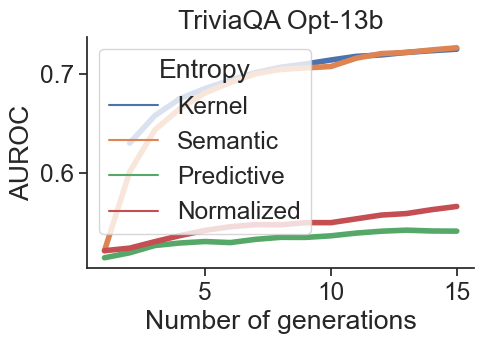

In [103]:
plt.figure(figsize=(5, 3))
sns.set(font_scale=1.6)
sns.set_style('ticks')
line_size = 4
plot = sns.lineplot(data=overall_results, y='AUROC', x='n_gens', hue='Entropy', linewidth=line_size)
plot.set_title('TriviaQA Opt-13b')
plot.set_xlabel('Number of generations')
sns.despine(plot.figure)
plot.figure.savefig('plots/opt13_trivia_kernel_entropy_ablation.pdf', bbox_inches='tight')
plot.figure.show();

In [90]:
overall_results[overall_results['n_gens']==10]

,rep_id,n_gens,AUROC,Entropy
8,0,10,0.709822,Kernel
17,1,10,0.709817,Kernel
26,2,10,0.709814,Kernel
35,3,10,0.709819,Kernel
44,4,10,0.709812,Kernel
53,5,10,0.709833,Kernel
62,6,10,0.709817,Kernel
71,7,10,0.709819,Kernel
80,8,10,0.709816,Kernel
89,9,10,0.709817,Kernel


/var/folders/ft/r9cj4sz92lbfcwssbtg9tp680000gp/T/ipykernel_3797/3206614577.py:44: UserWarning: Matplotlib is currently using module://matplotlib_inline.backend_inline, which is a non-GUI backend, so cannot show the figure.
  plot.figure.show();


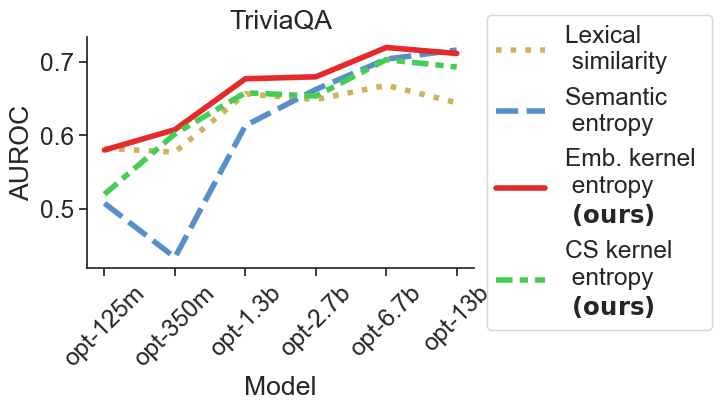

In [37]:
palette = {
    'Predictive \n entropy': '#9c816e',
    'Normalised \n entropy': '#d15cb0',
    'p(True)': '#40943e',
    'Lexical \n similarity': '#d1b25c', #'#949400',
    'Semantic \n entropy': '#588ecc',#'#1A92CA',
    'Emb. kernel \n entropy \n $\mathbf{(ours)}$': '#e62929', #'#e63946',
    'CS kernel \n entropy \n $\mathbf{(ours)}$': '#47cc55'
}
plt.figure(figsize=(5, 3))
sns.set(font_scale=1.6)
sns.set_style('ticks')
line_size = 4

cols_rename = {
    chosen_embedder: 'Emb. kernel \n entropy \n $\mathbf{(ours)}$',
    'Predictive Entropy': 'Predictive \n entropy',
    'Semantic Entropy': 'Semantic \n entropy',
    'Normalised Entropy': 'Normalised \n entropy',
    'Lexical Similarity': 'Lexical \n similarity',
}
sub_df = results_df[keys_sota_renamed+[chosen_embedder]][rows_trivia_m10].copy()
sub_df = sub_df[['Lexical Similarity', 'Semantic Entropy', 'k_entropy_rbf_e5-small-v2']]
sub_df.rename(columns=cols_rename, inplace=True)
# manually copied these values from the output files
sub_df['CS kernel \n entropy \n $\mathbf{(ours)}$'] = [0.520013, 0.602131, 0.657926, 0.653368, 0.702967, 0.692874]
plot = sns.lineplot(data=sub_df, linewidth=line_size, palette=palette)
plot.set_title('TriviaQA')
plot.set_ylabel("AUROC")
plot.set_xlabel("Model")
plot.axes.tick_params(axis='x', rotation=45)
sns.despine(plot.figure)
lines = plt.legend().get_lines()
for line in lines:
    line.set_linewidth(4)
lines[0].set_linestyle('dotted')
lines[2].set_linestyle('-')
plot.axes.lines[0].set_linestyle('dotted')
plot.axes.lines[2].set_linestyle('-')
sns.move_legend(plot, "upper left", bbox_to_anchor=(1, 1.15))
save_name = 'plots/nlg_results_sota_ext_trivia_m10_rebuttal'
plot.figure.savefig(save_name+'.pdf', bbox_inches='tight')
plot.figure.savefig(save_name+'.png', bbox_inches='tight')
plot.figure.show();

/var/folders/ft/r9cj4sz92lbfcwssbtg9tp680000gp/T/ipykernel_3797/569751951.py:43: UserWarning: Matplotlib is currently using module://matplotlib_inline.backend_inline, which is a non-GUI backend, so cannot show the figure.
  plot.figure.show();


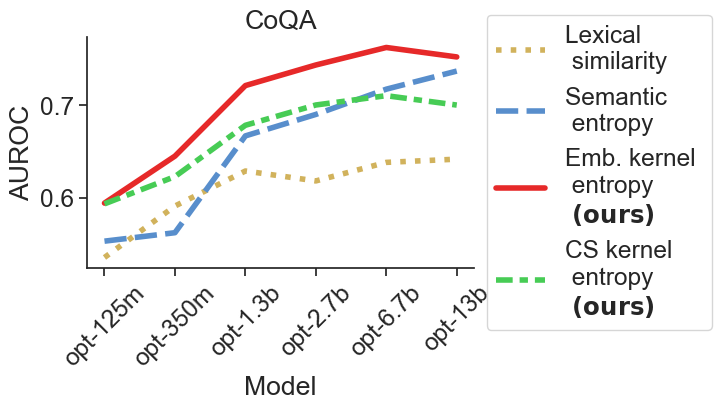

In [36]:
palette = {
    'Predictive \n entropy': '#9c816e',
    'Normalised \n entropy': '#d15cb0',
    'p(True)': '#40943e',
    'Lexical \n similarity': '#d1b25c', #'#949400',
    'Semantic \n entropy': '#588ecc',#'#1A92CA',
    'Emb. kernel \n entropy \n $\mathbf{(ours)}$': '#e62929', #'#e63946',
    'CS kernel \n entropy \n $\mathbf{(ours)}$': '#47cc55'
}
cols_rename = {
    chosen_embedder: 'Emb. kernel \n entropy \n $\mathbf{(ours)}$',
    'Predictive Entropy': 'Predictive \n entropy',
    'Semantic Entropy': 'Semantic \n entropy',
    'Normalised Entropy': 'Normalised \n entropy',
    'Lexical Similarity': 'Lexical \n similarity',
}
plt.figure(figsize=(5, 3))
sns.set(font_scale=1.6)
sns.set_style('ticks')
line_size = 4

sub_df = results_df[keys_sota_renamed+[chosen_embedder]][rows_coqa_m20].copy()
sub_df = sub_df[['Lexical Similarity', 'Semantic Entropy', 'k_entropy_rbf_e5-small-v2']]
sub_df.rename(columns=cols_rename, inplace=True)
sub_df['CS kernel \n entropy \n $\mathbf{(ours)}$'] = [0.593553, 0.623019, 0.678499, 0.700431, 0.710489, 0.700337]
plot = sns.lineplot(data=sub_df, linewidth=line_size, palette=palette)
plot.set_ylabel("AUROC")
plot.set_xlabel("Model")
plot.set_title('CoQA')
plot.axes.tick_params(axis='x', rotation=45)
sns.despine(plot.figure)
lines = plt.legend().get_lines()
for line in lines:
    line.set_linewidth(4)
lines[0].set_linestyle('dotted')
lines[2].set_linestyle('-')
plot.axes.lines[0].set_linestyle('dotted')
plot.axes.lines[2].set_linestyle('-')
sns.move_legend(plot, "upper left", bbox_to_anchor=(1, 1.15))
save_name = 'plots/nlg_results_sota_coqa_m20_rebuttal'
plot.figure.savefig(save_name+'.pdf', bbox_inches='tight')
plot.figure.savefig(save_name+'.png', bbox_inches='tight')
plot.figure.show();